# Adaptive PDE discretizations on cartesian grids 
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Isotropic metrics

In this notebook, we solve isotropic eikonal equations on the CPU and the GPU, and check that they produce consistent results.

We obtain substantial accelerations on sufficiently large instances, a few million points, by a factor up to $100$. Note that smaller test cases yield less acceleration, due to the difficulty to extract parallelism.

**bit-consistency.** By design, the CPU and GPU codes produce the same values, up to machine precision, which is approximately $10^{-8}$ for floating point types, in a variety on situations. 
This is due to the fact that the two implementations, although widely different, solve the same discretized problem. We try to ensure this behavior and check it as much as possible, as it is a strong indicator of the validity of the implementations. We refer to it as bit-consistency, aknowledging that it is a bit abusive, since the algorithm outputs, while extremely close, are still far from a bit-for-bit match.

**GPU/CPU speedup.**  General purpose graphical processors are massively parallel machines, which greatly outperform CPUs on embarassingly parallel tasks. The acceleration due to GPUs is therefore most impressive on large test cases.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Three dimensions](#1.-Three-dimensions)
  * [2. Two dimensions](#2.-Two-dimensions)
  * [3. GPU specific options](#3.-GPU-specific-options)
    * [3.1 Multiprecision and convergence tolerance](#3.1-Multiprecision-and-convergence-tolerance)
    * [3.2 Block shape and inner iterations](#3.2-Block-shape-and-inner-iterations)
    * [3.3 Periodicity](#3.3-Periodicity)
    * [3.4 Help and parameter defaults](#3.4-Help-and-parameter-defaults)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Isotropic_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
Eikonal.dictIn.default_mode = 'gpu'

DeliberateNotebookError: Cupy module required

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen
    Eikonal,ad,cugen = rreload([Eikonal,ad,cugen],"..")
    Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

In [5]:
large_instances = True # Set to True to show off GPU acceleration (CPU times may become a big long.)

### 0.2 Decorations for gpu usage

Dealing with GPU data induces minor inconveniences:
- GPU arrays are not implicitly convertible to CPU arrays, and this is a good thing since memory transfers from GPU memory to CPU memory, and conversely, are not cheap. The `get` method must be applied to a cupy array to retrieve a numpy array.
- GPU computing is much more efficient with 32 bit data types, integer and floating point, than with their 64bit counterparts. However a number of numpy and cupy basic functions default to 64bit output, which will be inconsistent with the rest of computations.

We provide decorators to perform these memory transfers and data type conversions automatically. They are only applied to specific modules and functions, below, to avoid excessive implicit operations. 

In [6]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

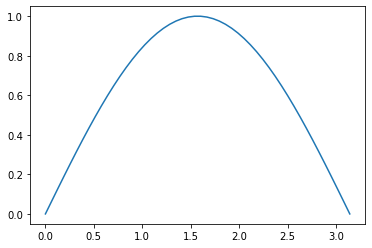

In [7]:
X = cp.linspace(0,np.pi) # 64 bit output is converted to 32 bit by decorator
plt.plot(X,np.sin(X));   # GPU array is transfered to CPU memory.

Note that, by default, these decorators do not apply to the system module, but only to a shallow copy.

In [8]:
sys.modules['cupy'].linspace(0,np.pi).dtype

dtype('float64')

### 0.3 Comparing CPU and GPU results

In [9]:
variants_basic = (
    [{},{"seedRadius":2.}], # Spread seed information ?
    [{},{'multiprecision':True}] # Reduce floating point roundoff errors
)

variants_ext = (
    [{},{"seedRadius":2.},{"factoringRadius":10.,'factoringPointChoice':'Key'}], # source factorization ?
    [{},{'multiprecision':True}] # Reduce floating point roundoff errors
)

variants_ext2 = (
    [{},{'order':2}], # second order scheme ?
    [{},{"seedRadius":2.},{"factoringRadius":10.,'factoringPointChoice':'Key'}], # source factorization ?
    [{},{'multiprecision':True}] # Reduce floating point roundoff errors
)


In [10]:
def RunCompare(gpuIn,check=True,check_ratio=0,variants=None,**kwargs):
    # Dispatch the common variants if requested
    if isinstance(variants,str): variants = {'basic':variants_basic,'ext':variants_ext,'ext2':variants_ext2}[variants]
    if variants:
        for variant in variants[0]:
            RunCompare(gpuIn,check=check,check_ratio=check_ratio,variants=variants[1:],**kwargs,**variant)
        return

    if kwargs: print("\n",f"--- Variant {kwargs} ---")

    # Run the CPU and GPU solvers
    gpuIn = gpuIn.copy(); gpuIn.update(kwargs)
    gpuOut = gpuIn.Run()
    if gpuIn.get('verbosity',1):  print(f"--- gpu done, turning to cpu ---")
    cpuOut = gpuIn.Run(join={'mode':'cpu_transfer'})
    
    # Print performance info
    fmTime = cpuOut['FMCPUTime']; stencilTime = cpuOut['StencilCPUTime']; 
    cpuTime = fmTime+stencilTime; gpuTime = gpuOut['solverGPUTime'];
    print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
    
    # Check consistency 
    cpuVals = cpuOut['values'].copy(); gpuVals = gpuOut['values'].get()
    # Inf is a legitimate value in the presence of e.g. obstacles
    commonInfs = np.logical_and(np.isinf(cpuVals),np.isinf(gpuVals)) 
    cpuVals[commonInfs]=0; gpuVals[commonInfs]=0
    print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuVals-cpuVals))
    
    if check is True: assert np.allclose(gpuVals,cpuVals,atol=1e-5,rtol=1e-4)
    elif check is False: pass
    else: assert np.sum(np.abs(gpuVals-cpuVals)>check)<=check_ratio*gpuVals.size

    return gpuOut,cpuOut

## 1. Three dimensions

GPU acceleration shines particularly well in three dimensions, where we get accelerations by a factor $100$ on large instances.

### 1.1 Constant metric

In [11]:
n = 200 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Isotropic3',
    'seed':[0.,0.5,1.],
    'exportValues':1,
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [12]:
RunCompare(hfmIn);

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.15620803833007812 seconds, and 177 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 6.297 s.
Solver time (s). GPU : 0.15620803833007812, CPU : 6.3229999999999995. Device acceleration : 40.47807057559403
Max |gpuValues-cpuValues| :  7.525086402893066e-07


### 1.2 Scheme variants

We check bit-consistency for a few variants of the scheme.

In [13]:
n=50; hfmInS = hfmIn.copy() # Define the a smaller instance
hfmInS.SetRect([[0,1],[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'seed':[0,0,0],
    'cost': np.prod(np.sin(2*np.pi*X),axis=0) + 1.1, # Non-constant cost
    'verbosity':0,
})

In [14]:
RunCompare(hfmInS,variants='basic');

Solver time (s). GPU : 0.02162003517150879, CPU : 0.065. Device acceleration : 3.006470594722158
Max |gpuValues-cpuValues| :  6.863284829350391e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.022937536239624023, CPU : 0.066. Device acceleration : 2.8773796501294084
Max |gpuValues-cpuValues| :  9.15195275119629e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.020945072174072266, CPU : 0.068. Device acceleration : 3.2465870461013093
Max |gpuValues-cpuValues| :  7.071241174827492e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.021939992904663086, CPU : 0.066. Device acceleration : 3.0082051660997795
Max |gpuValues-cpuValues| :  9.278738799523012e-08


The second order scheme implementation, and the source factorization, have some slight differences between the GPU and CPU implementation, hence *one cannot expect bit-consistency in general*. 

In [15]:
RunCompare(hfmInS,variants='ext2',check=0.03);

Solver time (s). GPU : 0.021941423416137695, CPU : 0.065. Device acceleration : 2.9624331460735203
Max |gpuValues-cpuValues| :  6.863284829350391e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.023935556411743164, CPU : 0.065. Device acceleration : 2.7156251929915434
Max |gpuValues-cpuValues| :  9.15195275119629e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.021940946578979492, CPU : 0.066. Device acceleration : 3.0080744129440276
Max |gpuValues-cpuValues| :  7.071241174827492e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.021941184997558594, CPU : 0.066. Device acceleration : 3.0080417264310864
Max |gpuValues-cpuValues| :  9.278738799523012e-08

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---


..\agd\AutomaticDifferentiation\Base.py:24: RuntimeWarning: divide by zero encountered in power
  def pow(x,n):	return (x**n,n*x**(n-1))
..\agd\AutomaticDifferentiation\Dense.py:95: RuntimeWarning: invalid value encountered in multiply
  return self.new(a,_add_dim(b)*self.coef)


Solver time (s). GPU : 0.020943403244018555, CPU : 0.065. Device acceleration : 3.10360256366472
Max |gpuValues-cpuValues| :  0.007725296621633626

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key', 'multiprecision': True} ---
Solver time (s). GPU : 0.022899150848388672, CPU : 0.066. Device acceleration : 2.882202944422464
Max |gpuValues-cpuValues| :  0.007725266819311238

 --- Variant {'order': 2} ---
Solver time (s). GPU : 0.031914472579956055, CPU : 0.095. Device acceleration : 2.9767059368439925
Max |gpuValues-cpuValues| :  0.00820210289993728

 --- Variant {'order': 2, 'multiprecision': True} ---
Solver time (s). GPU : 0.02988576889038086, CPU : 0.097. Device acceleration : 3.2456919664938173
Max |gpuValues-cpuValues| :  0.00820210289993728

 --- Variant {'order': 2, 'seedRadius': 2.0} ---
Solver time (s). GPU : 0.030884981155395508, CPU : 0.097. Device acceleration : 3.1406850958383834
Max |gpuValues-cpuValues| :  0.011129541346007632

 --- Variant {'order': 2,

### 1.3 Variable metric

In [16]:
def cost(x,eps=0.1):
    r = fd.as_field(lp.rotation(cp.array(np.pi/3),axis=cp.array((1,2,3.))),x.shape[1:],depth=2)
    y = lp.dot_AV(r,x)
    c,s = np.cos(y)**2,np.sin(y)**2
    return eps**2 + c[0]*s[1]*s[2] + s[0]*c[1]*s[2] + s[0]*s[1]*c[2]

In [17]:
n=300 if large_instances else 100
hfmIn = Eikonal.dictIn({
    'model':'Isotropic3',
    'seed':(0,0,0),
#    'traits':{'niter_i':8},'fim_front_width':4,
})
hfmIn.SetRect([[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]],dimx=n+1)
X = hfmIn.Grid()
hfmIn['cost'] = cost(X,eps=0.05)

In [18]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.7679600715637207 seconds, and 226 iterations.
Post-Processing


## 2. Two dimensions

In two dimensions, it is usually more difficult to extract parallism than in three dimensions.
Indeed, the front propagated in the computations is expected to have approximately
$$
    N^{\frac{d-1} d}
$$
points in dimension $d$, where $N$ denotes the total number of points in the domain. 
The front in a two dimensional computation thus has $N^{\frac 1 2}$ points which is much fewer than $N^{\frac 2 3}$ in three dimensions, when $N$ is large. In addition the number of points $N$ is also often fewer in two dimensional problems.

In [19]:
n=4000 if large_instances else 1000
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.,0.5],
    'exportValues':1,
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [20]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-4)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.24227356910705566 seconds, and 251 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 5.316 s.
Solver time (s). GPU : 0.24227356910705566, CPU : 5.364. Device acceleration : 22.14026077945696
Max |gpuValues-cpuValues| :  7.011341259088866e-05


Another annoyance is that the numerical error, close to $10^{-4}$ in the large instance, is not as good as could be expected, around $10^{-7}$ for single precision floating point types. 
A quick fix, explained in more detail below and which does have a computational cost, is to run the computation using multiprecision.

In [21]:
gpuOut = hfmIn.Run(join={'multiprecision':True}) # join with another dict
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.40174365043640137 seconds, and 251 iterations.
Post-Processing
Max |gpuValues-cpuValues| :  7.819931724384332e-08


In [22]:
n=50; hfmInS = hfmIn.copy() # Define a small instance for bit-consistency validation
hfmInS.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X = hfmInS.Grid()
hfmInS.update({
    'cost':np.prod(np.sin(2*np.pi*X),axis=0) +1.1, # Non-constant cost
    'verbosity':0,
})

In [23]:
RunCompare(hfmInS,variants='basic')

Solver time (s). GPU : 0.00299072265625, CPU : 0.001. Device acceleration : 0.3343673469387755
Max |gpuValues-cpuValues| :  2.744794124209804e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.003023862838745117, CPU : 0.001. Device acceleration : 0.3307028305605929
Max |gpuValues-cpuValues| :  8.610952284549e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.0019617080688476562, CPU : 0.0. Device acceleration : 0.0
Max |gpuValues-cpuValues| :  3.261127631271066e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.015620708465576172, CPU : 0.0. Device acceleration : 0.0
Max |gpuValues-cpuValues| :  9.196985217840847e-08


Again, bit consistency is not expected with the second order scheme.

<!---
, but not excluded either.
Note that the second order scheme is non-monotone, hence the solution values need not decrease as the iterations proceed. 
In order to be consistent with the CPU implementation, and validate this test, we set the trait `decreasing_macro` to $0$.
--->

In [24]:
RunCompare(hfmInS,variants='ext2',check=0.02)

Solver time (s). GPU : 0.003621816635131836, CPU : 0.001. Device acceleration : 0.2761045355802778
Max |gpuValues-cpuValues| :  2.744794124209804e-07

 --- Variant {'multiprecision': True} ---
Solver time (s). GPU : 0.0030355453491210938, CPU : 0.0. Device acceleration : 0.0
Max |gpuValues-cpuValues| :  8.610952284549e-08

 --- Variant {'seedRadius': 2.0} ---
Solver time (s). GPU : 0.002960205078125, CPU : 0.001. Device acceleration : 0.3378144329896907
Max |gpuValues-cpuValues| :  3.261127631271066e-07

 --- Variant {'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.0, CPU : 0.0. Device acceleration : nan
Max |gpuValues-cpuValues| :  9.196985217840847e-08

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.0, CPU : 0.001. Device acceleration : inf
Max |gpuValues-cpuValues| :  0.0033232242635053144

 --- Variant {'factoringRadius': 10.0, 'factoringPointChoice': 'Key', 'multiprecision': True} ---
Solver time (s). GPU 

<ipython-input-10-eef1738a2fdf>:20: RuntimeWarning: invalid value encountered in double_scalars
  print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")
<ipython-input-10-eef1738a2fdf>:20: RuntimeWarning: divide by zero encountered in double_scalars
  print(f"Solver time (s). GPU : {gpuTime}, CPU : {cpuTime}. Device acceleration : {cpuTime/gpuTime}")


Solver time (s). GPU : 0.0, CPU : 0.001. Device acceleration : inf
Max |gpuValues-cpuValues| :  0.002891281617866337

 --- Variant {'order': 2, 'multiprecision': True} ---
Solver time (s). GPU : 0.004957914352416992, CPU : 0.001. Device acceleration : 0.2016977157970666
Max |gpuValues-cpuValues| :  0.00289020873426038

 --- Variant {'order': 2, 'seedRadius': 2.0} ---
Solver time (s). GPU : 0.015654325485229492, CPU : 0.001. Device acceleration : 0.06388010782984815
Max |gpuValues-cpuValues| :  0.012899741741463189

 --- Variant {'order': 2, 'seedRadius': 2.0, 'multiprecision': True} ---
Solver time (s). GPU : 0.0, CPU : 0.001. Device acceleration : inf
Max |gpuValues-cpuValues| :  0.012899831148430352

 --- Variant {'order': 2, 'factoringRadius': 10.0, 'factoringPointChoice': 'Key'} ---
Solver time (s). GPU : 0.0, CPU : 0.001. Device acceleration : inf
Max |gpuValues-cpuValues| :  0.007805930036696607

 --- Variant {'order': 2, 'factoringRadius': 10.0, 'factoringPointChoice': 'Key', 'm

### 1.3 Variable metric

In [25]:
def cost(x,eps=0.1):
    r = fd.as_field(lp.rotation(cp.array(np.pi/3)),x.shape[1:],depth=2)
    y = lp.dot_AV(r,x)
    return eps**2 + np.sin(y[0])**2 * np.cos(y[1])**2 + np.cos(y[0])**2 * np.sin(y[1])**2 

In [26]:
n=2000 if large_instances else 200
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':(0,0),
    'exportValues':True,
#    'traits':{'shape_i':(24,24),'niter_i':48},
})
hfmIn.SetRect([[-2*np.pi,2*np.pi],[-2*np.pi,2*np.pi]],dimx=n+1)
X = hfmIn.Grid()
hfmIn['cost'] = cost(X,eps=0.05)

In [27]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.24659323692321777 seconds, and 98 iterations.
Post-Processing


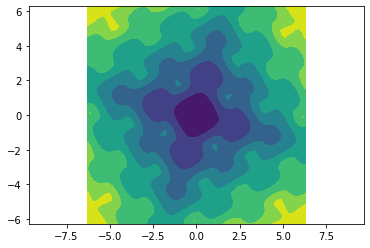

In [28]:
plt.contourf(*X,hfmOut['values'])
plt.axis('equal');

## 3. GPU specific options

The RunGPU method of the HFM has a number of parameters, usually set to reasonnable defaults. We discuss a few of them below.

### 3.1 Multiprecision and convergence tolerance

**Multiprecision.** In this mode, the solution values are represented as pairs 
$$
    u(x) = u_q(x) \delta + u_r(x),
$$
where $u_q(x) \in Z$ is an integer, $\delta>0$ is a fixed scale, and $u_r(x) \in [-\delta/2,\delta/2[$.

The parameter $\delta$ is set automatically as the largest power of two (usually a negative power) bounded by $h/10$, where $h$ is the grid scale. The choice of a power of two avoids roundoff errors.

<!---
Eventually, the result is converted to floating point format. A slightly better accuracy can be obtained by using a double type in this last step.
gpuOut = RunGPU({**hfmIn,'values_float64':True})
print("Max |gpuValues-cpuValues| : ", norm_infinity(gpuOut['values'].get()-cpuOut['values']))
--->

**Convergence tolerance.** This parameter sets the tolerance for the convergence of the fixed point solver.
When setting the convergence tolerance, it is important to keep in mind the *resolution* of the chosen floating point type.

In [29]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [30]:
np.finfo(np.float64)

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

A typical value for tolerance, in *multi-precision* mode is 
$$
    tol=res*h*M,
$$
where $h$ is the grid scale, $res$ is the resolution of the floating point type, and $M$ is the magnitude of cost function in the case of an isotropic metric, or a related quantity in the anisotropic case.

Without multiprecision, the above tolerance value should be multiplied by the grid scale.

Caveats:
- Choosing an excessively small tolerance, may increase the number of iterations of the solver (especially in multi-precision mode according to our experiments). In fact, the solver may not converge at all.
- Choosing a excessively large tolerance may reduce accuracy.

### 3.2 Block shape and inner iterations

The GPU implementation of the fast marching method works by grouping together blocks of grid points, which are updated simultaneously a prescribed number of times. The shape of these blocks ` shape_i`  and number of iterations `niter_i` can be modified, which may affect performance. They are collected in the `traits` input parameter, together with a number of compile time constants and typedefs for the GPU kernel.

In [31]:
gpuOut['keys']['default']['traits']

{'Scalar': numpy.float32,
 'Int': numpy.int32,
 'OffsetT': numpy.int32,
 'pruning_macro': False,
 'geom_first_macro': True,
 'shape_i': (24, 24),
 'niter_i': 48,
 'multiprecision_macro': True,
 'strict_iter_o_macro': True,
 'strict_iter_i_macro': True,
 'ndim_macro': 2,
 'geom_indep_macro': 2,
 'import_scheme_macro': False,
 'local_i_macro': True,
 'periodic_macro': False,
 'isotropic_macro': True,
 'walls_macro': False}

### 3.3 Periodicity

Standard periodic boundary conditions may be applied to one or several some axes.

In [32]:
n=48
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.2,0.4],
    'exportValues':1,
    'cost':1.,
    'verbosity':1,
    'periodic':(False,True) # Periodic along second axis
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=False)

In [33]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.002956867218017578 seconds, and 6 iterations.
Post-Processing


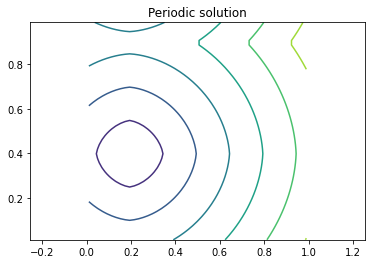

In [34]:
X = hfmIn.Grid()
plt.title('Periodic solution'); plt.axis('equal')
plt.contour(*X,gpuOut['values']); 

### 3.4 Help and parameter defaults

The HFM algorithm sets a number of parameters to (hopefull relevant) default values. 
Setting a verbosity equal or larger than two will display some of the associated values.

In [35]:
n=200
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seed':[0.,0.5],
    'exportValues':1,
    'cost':1.,
    'verbosity':2
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)

In [36]:
gpuOut = hfmIn.Run()

key clear_hfmIn defaults to False
Setting the kernel traits.
key traits defaults to {'Scalar': <class 'numpy.float32'>, 'Int': <class 'numpy.int32'>, 'OffsetT': <class 'numpy.int32'>, 'pruning_macro': False, 'geom_first_macro': True, 'shape_i': (24, 24), 'niter_i': 48}
key values_float64 defaults to False
key multiprecision defaults to False
key factoringRadius defaults to 0
key order defaults to 1
key bound_active_blocks defaults to False
key solver defaults to AGSI
Preparing the domain data (shape,metric,...)
key periodic defaults to (False, False)
key exportGeodesicFlow defaults to False
key tips defaults to None
key costVariation defaults to None
see out['keys']['default'][tol] for default
key atol defaults to 2.4999984e-08
key rtol defaults to 4.9999999873762135e-06
key walls defaults to None
Preparing the problem rhs (cost, seeds,...)
key values defaults to None
key seedValues defaults to [    0]
key seedValueVariation defaults to None
key seedRadius defaults to 0.0
Preparing the

The default values of the keys and values are provided in the output.

In [37]:
gpuOut['keys']['default']

OrderedDict([('verbosity', 1),
             ('clear_hfmIn', False),
             ('model', '_None'),
             ('traits',
              {'Scalar': numpy.float32,
               'Int': numpy.int32,
               'OffsetT': numpy.int32,
               'pruning_macro': False,
               'geom_first_macro': True,
               'shape_i': (24, 24),
               'niter_i': 48,
               'multiprecision_macro': False,
               'ndim_macro': 2,
               'geom_indep_macro': 2,
               'import_scheme_macro': False,
               'local_i_macro': True,
               'periodic_macro': False,
               'isotropic_macro': True,
               'walls_macro': False}),
             ('values_float64', False),
             ('multiprecision', False),
             ('factoringRadius', 0),
             ('order', 1),
             ('bound_active_blocks', False),
             ('solver', 'AGSI'),
             ('periodic', (False, False)),
             ('gridScale', '_Non

A succint help on the role of each key can be displayed.

In [38]:
gpuOut['keys']['help']

OrderedDict([('verbosity', 'Choose the amount of detail displayed on the run'),
             ('clear_hfmIn', 'Delete hfmIn member fields. (May save memory.)'),
             ('model', 'Minimal path model to be solved.'),
             ('traits', 'Optional trait parameters for the eikonal kernel.'),
             ('values_float64', 'Export values using the float64 data type'),
             ('multiprecision',
              'Use multiprecision arithmetic, to improve accuracy'),
             ('factoringRadius',
              'Use source factorization, to improve accuracy'),
             ('order', 'Use second order scheme to improve accuracy'),
             ('bound_active_blocks',
              'Limit the number of active blocks in the front. Admissible values : (False,True, or positive integer)'),
             ('solver',
              'Choice of fixed point solver (AGSI, global_iteration)'),
             ('periodic', 'Apply periodic boundary conditions on some axes'),
             ('gridScale